<center>

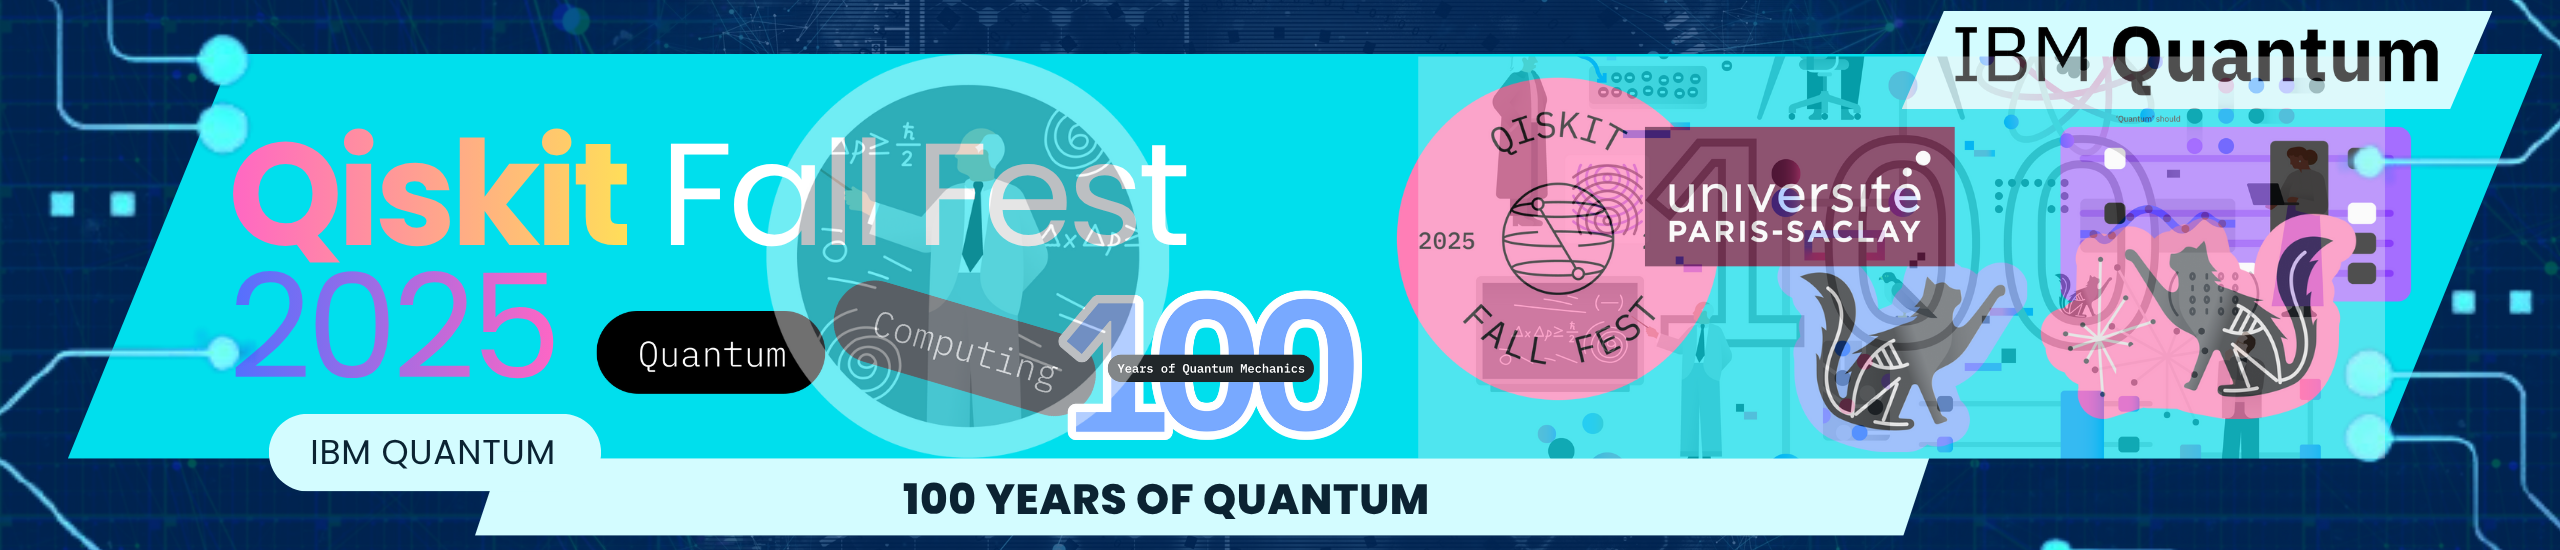

</center>

# 2025 Qiskit Fall Fest @ University Paris Saclay - Quantum algorithms: Variational quantum algorithms

# Table of Contents

* [Part 1: Introduction and install requirements](##-1.-introduction)
* [Part 2: Variational Quantum Eigensolver](#part-2-variational-quantum-eigensolver)
    * Computing simple Hamiltonian using VQE
        * [Exercise 1](#exercise1): Build your first cost function for the hybrid loop
        * [Exercise 2](#exercise2): Apply to other simple Hamiltonian
* [Part 3: Quantum Optimization Problems and Quantum Approximate Optimization Algorithm (QAOA)](#part-3-what-is-sample-based-quantum-diagonalization-(SQD)?)
    * Quadractic program: Reconstruct the Hamiltonian with 'good samples'
    * MaxCut problem
        * [Exercise 3](#exercise3): Construct Maxcut problem
        * [Exercise 4](#exercise4): Maxcut as QUBO optimization problem
    * From QUBO to Hamiltonian
        * [Exercise 5](#exercise5): Construct variational form to QAOA ansatz
        * [Exercise 6](#exercise6): Construct Hamiltonian based on QUBO optimization
    * Run QAOA on Qiskit
        * [Exercise 7](#exercise7): Construct Cost function for QAOA optimization
    * Post processing
    * The Qiskit end-to-end QAOA class

## 1. Introduction

This tutorial provides an overview of a hybrid quantum-classical algorithm, specifically focusing on the variational quantum eigensolver (VQE), Sampling-based Quantum Diagonalization (SQD), and the quantum approximate optimization algorithm (QAOA). The primary objective of these algorithms is to tackle optimization problems by employing quantum circuits with parameterized quantum gates.

Despite the advancements in quantum computing, the presence of noise in current quantum devices makes it challenging to extract meaningful results from deep quantum circuits. To overcome this challenge, VQE, SQD and QAOA adopt a hybrid quantum-classical approach, which involves iteratively executing relatively short quantum circuits using quantum computation and optimizing the parameters of the target parametrized quantum circuits using classical computation.

QAOA has the potential to provide the optimal solutions to the target problems at a utility scale, thanks to the application of various error mitigation and suppression techniques. VQE has many applications (like quantum chemistry) in which it is less scalable. But there have been a number of eigenvalue-related approaches that have emerged to complement and augment VQE, including Krylov subspace diagonalization and SQD. Understanding VQE is an important first step in understanding the wide range of classical-quantum hybrid algorithms that have emerged.

This module describes the fundamental concepts and implementation of VQE and QAOA
- variational quantum algorithms, in particular Variational Quantum Eigensolvers
- how to create and work with parameterized circuits and quadratic programs in Qiskit
- how to solve optimization problems using QAOA

You require the following library in your environment to run this notebook. If you have not installed it yet, you can install it by un-commenting and running the following cell.


In [ ]:
# Install qiskit
# !pip install qiskit
# !pip install qiskit-ibm-runtime
# !pip install qiskit[visualization]
# !pip install qiskit-optimization


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
zsh:1: no matches found: qiskit[visualization]

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [nbformat]

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [ ]:
import numpy as np
from qiskit.circuit import ParameterVector, QuantumCircuit
from qiskit.primitives import StatevectorEstimator, StatevectorSampler
from qiskit.quantum_info import SparsePauliOp
from scipy.optimize import minimize

In the most general sense, a variational quantum circuit is a circuit that depends on a set of parameters $\theta$. Typically, a variational quantum algorithm queries a quantum computer to sample the output of this parameterized quantum circuit for some fixed parameters and evaluates a given cost function $C(\theta)$ based on this output. A classical optimizer is then used to update the circuit parameters in order to maximize or minimize the objective function $C$. These steps are repeated in a quantum-classical hybrid loop that eventually terminates when the classical optimization has found optimal parameters $\theta^*$.<br>

Variational Quantum Algorithms are often seen as a promising method of achieving quantum advantage on near term devices. In a lot of cases they do not require the execution of deep quantum circuits and systematic errors can partly be mitigated by outsourcing the optimization procedure to a classical optimizer. Nevertheless, VQAs also face a number of challenges, in particular the questions of whether they are efficiently trainable and produce solutions that are in fact superior to those obtained by classical algorithms.
Despite these challenges, VQAs have been proposed for a variety of problem settings, amongst others the following.

- **Variational Quantum Eigensolvers**:
VQEs attempt to approximate the ground state and corresponding energy of a quantum system described by a Hamiltonian $H$ (i.e. the lowest eigenvalue and eigenvector of the corresponding hermitian matrix).

- **QAOA**: An approximate optimization algorithm used for combinatorial optimization problems. QAOA can be seen as a VQE that solves optimization problems by encoding the cost function as a problem Hamiltonian (see [Section 3](#3.-Quantum-Optimization-Problems-and-Quantum-Approximate-Optimization-Algorithm-(QAOA))).

- **Variational Classifiers**: A variational classifier is a quantum circuit that is trained on a data set to classify unseen data samples, reminiscent of classical machine learning classifiers.

- **Variational Quantum Linear Solvers**: VQLS solves systems of linear equations by leveraging the basic ideas behind VQEs.



In this lab, we will focus on QAOA as a special case of the Variational Quantum Eigensolver.

## 2. Variational Quantum Eigensolvers
\label{qaoa}
Consider a Hermitian operator $\hat{H}$ describing a quantum system with corresponding ground state $\vert \psi^* \rangle$ and ground state energy $E_0$.
The variational method is a technique to approximate $\vert \psi^* \rangle$ and $E_0$. This is done by choosing a parameterized trial state $\vert \psi(\theta) \rangle = \hat{U}(\theta)\vert 0 \rangle$, where $\theta$ denotes a set or vector of parameters. Recall that the energy of the system in the state $\vert \psi \rangle$ is given by its expectation value with respect to $\hat{H}$
$$
E(\vert \psi \rangle)= \langle \psi \vert \hat{H} \vert \psi \rangle
$$
Since the ground state of the system is the lowest energy eigenstate, by definition it holds that
$$
E_0 = \langle \psi^* \vert \hat{H} \vert \psi^* \rangle \leq \langle \psi(\theta) \vert \hat{H} \vert \psi(\theta) \rangle,
$$
for any parameters $\theta$. Thus, by minimizing the expectation value of the trial state $\psi(\theta)$, that is, finding parameters $\theta$ for which the expectation value $\langle \psi(\theta) \vert \hat{H} \vert \psi(\theta) \rangle$ becomes as small as possible, we obtain an upper bound on the ground state energy $E_0$ and an approximation of the ground state itself. Naturally, the choice of a good trial state $\psi(\theta)$ is principal to the success of the variational method.

Variational quantum eigensolvers use the variational method to approximate the ground state and minimal eigenvalue of a Hamiltonian $\hat{H}$. The trial state now corresponds to a quantum state prepared by a variational quantum circuit and the corresponding expectation value is measured by executing the circuit on a quantum computer. A classical optimizer is then used to tune the circuit parameters and minimize the measured expectation value.<br>
<center>

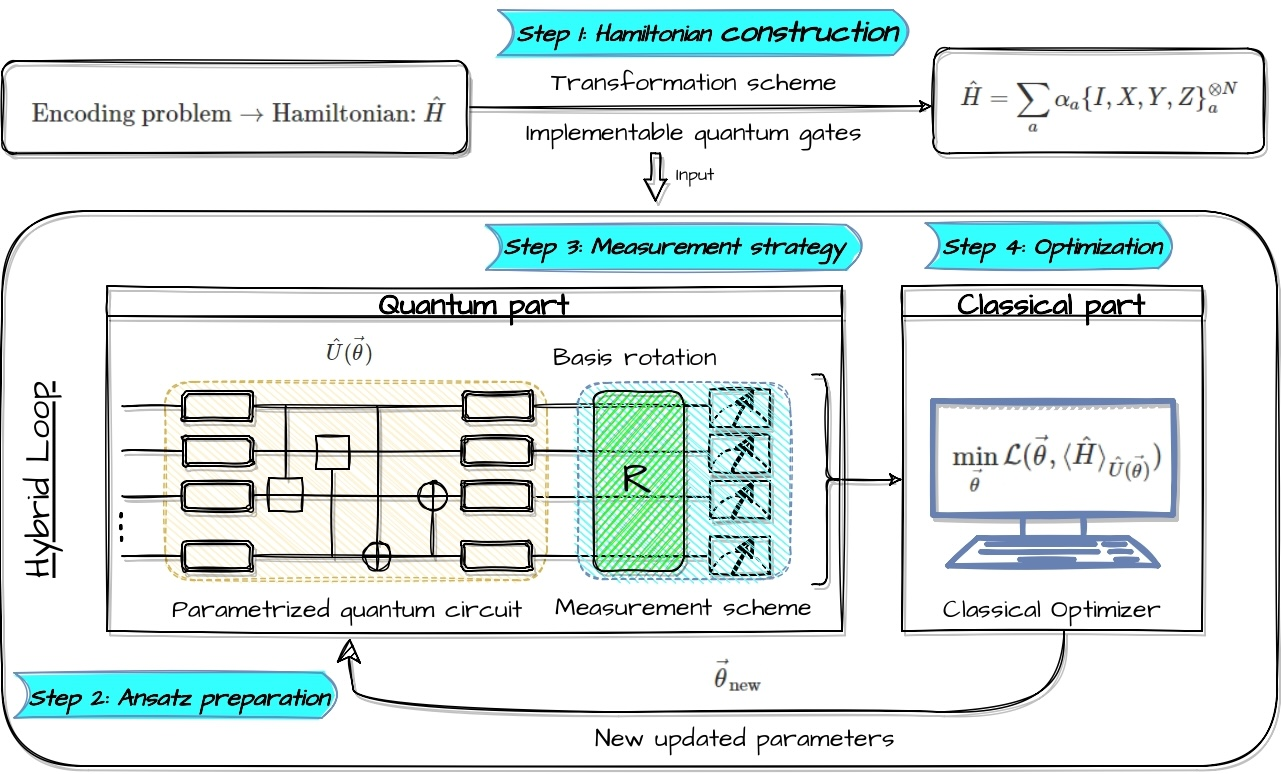


<figcaption> Variational Quantum Eigensolver paradigm.

Image source: [VQEworkflow.pdf.](https://arxiv.org/abs/2412.19176)
</figcaption>

</center>

Apart from being applicable to problems in chemistry or quantum mechanics itself, where we are directly interested in the ground state of a given Hamiltonian, one can also use the concept of variational quantum eigensolvers for optimization problems, by encoding the cost function that should be optimized as a Hamiltonian whose ground state corresponds to the optimal solution of the problem. This idea lies at the heart of QAOA.

### Computing the minimum eigenvalue of a simple Hamiltonian

We will start by applying VQE to a very simple case, to see how it works. We will compute the minimum eigenvalue of Pauli $Z$ matrix with VQE. We will start by importing some general packages.

In [ ]:
import numpy as np
from qiskit.circuit import ParameterVector, QuantumCircuit
from qiskit.primitives import StatevectorEstimator, StatevectorSampler
from qiskit.quantum_info import SparsePauliOp
from scipy.optimize import minimize

It is easy to obtain the eigenvalues by classical method (numpy package __np.linalg.eigh__). This might become difficult as we scale toward utility. Here we use numpy.

In [ ]:
# Let's get operator of interest
op = SparsePauliOp("Z")
print("Operator:\n", op)
print("Matrix:\n", op.to_matrix())
# compute eigenvalues with numpy
result = np.linalg.eigh(op.to_matrix())
print("Eigenvalues:", result.eigenvalues)
exact_minimum = np.min(result.eigenvalues)
print("Minimum eigenvalue:", exact_minimum)

Operator:
 SparsePauliOp(['Z'],
              coeffs=[1.+0.j])
Matrix:
 [[ 1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j]]
Eigenvalues: [-1.  1.]
Minimum eigenvalue: -1.0


To get into using VQE, we first construct a parametrized quantum circuit with gates that take variational parameters:

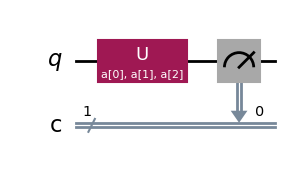

In [ ]:
# define a variational form
param = ParameterVector("a", 3)
qc = QuantumCircuit(1, 1)
qc.u(param[0], param[1], param[2], 0)
qc_estimator = qc.copy() # Circuit for Estimator
qc.measure(0, 0) # use measured circuit for Sampler
qc.draw("mpl")

There are two primitives to run experimentally the quantum circuit, if we want to estimate the expectation value of an operator (like $Z$), we should use Estimator, if we want to look at the states of the system, we use Sampler.

In [ ]:
sampler = StatevectorSampler()
estimator = StatevectorEstimator()

We assign a random parameter to parametrized circuit, and compute counts of bitstrings 0 and 1 using Sampler.

In [ ]:
# compute counts of bitstrings with random parameter values by Sampler
# set random parameters
np.random.seed(42)
params = list(np.random.rand(3))
print("Random parameters:", params)
# run quantum circuit with Sampler
result = sampler.run([(qc, [params])]).result()
# get counts from sampling result
counts = result[0].data.c.get_counts()
print("Counts:", counts)

Random parameters: [np.float64(0.3745401188473625), np.float64(0.9507143064099162), np.float64(0.7319939418114051)]
Counts: {'0': 993, '1': 31}


The expectation value of $Z$ is computed by $P_0-P_1$ proved via the other expression of pauli $Z = |0><0|-|1><0|$, where the probability $\{“0":P_0, “1":P_1\}$.

In [ ]:
# compute the expectation value of Z based on the counts
(counts.get("0", 0) - counts.get("1", 0)) / sum(counts.values())

0.939453125

or we can use Estimator dirrectly feeding the pre-defined operator in, the result is similar. Note that Estimator takes quantum circuits without measurements.

In [ ]:
result = estimator.run([(qc_estimator, op, params)]).result()
result[0].data.evs

array(0.93067597)

This circuit worked, but the parameter values chosen did not correspond to a very low-energy (or low-eigenvalue) state. The eigenvalue obtained is quite a bit higher than the minimum. We will need to search through parameters and find those that yield the lowest eigenvalue. We make a function to receive parameter values of the variational form and return the expectation value $<Z>$

__Sampler cost function__

In [ ]:
# define a cost function to look for the minimum eigenvalue of Z
def cost_sampler(x):
    result = sampler.run([(qc, x)]).result()
    counts = result[0].data.c.get_counts()
    expval = (counts.get("0", 0) - counts.get("1", 0)) / sum(counts.values())
    # the following line shows the trajectory of the optimization
    print(expval, counts)
    return expval

Let's apply `SciPy's` minimize function to find the minimum eigenvalue of Z.

In [ ]:
# Minimize the cost function with scipy's minimize
initial_params = [0, 0, 0] # Feeding initial parameters, all set to zero. In many cases, the guess of initial parameters would affect the optimization routine.
tol=1e-8 # Tolerance for termination of optimization.
min_result_sampler = minimize(cost_sampler,initial_params,method="COBYLA", tol=tol)
min_result_sampler

1.0 {'0': 1024}
0.556640625 {'1': 227, '0': 797}
0.576171875 {'0': 807, '1': 217}
0.466796875 {'0': 751, '1': 273}
-0.38671875 {'1': 710, '0': 314}
-0.71875 {'1': 880, '0': 144}
-0.486328125 {'1': 761, '0': 263}
-0.54296875 {'1': 790, '0': 234}
-0.169921875 {'0': 425, '1': 599}
-0.96484375 {'1': 1006, '0': 18}
-0.982421875 {'1': 1015, '0': 9}
-0.99609375 {'1': 1022, '0': 2}
-0.994140625 {'1': 1021, '0': 3}
-0.986328125 {'1': 1017, '0': 7}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-0.998046875 {'1': 1023, '0': 1}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-1.0 {'1': 1024}


 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -1.0
       x: [ 3.126e+00  2.544e-01  1.254e+00]
    nfev: 31
   maxcv: 0.0

In [ ]:
print("Exact minimum eigenvalue:", exact_minimum)
print("Minimum eigenvalue found:", min_result_sampler.fun)

Exact minimum eigenvalue: -1.0
Minimum eigenvalue found: -1.0


<div id='problem1'></div>
<div class="alert alert-block alert-success">

**Excercise 1**
<br>
In this exercise, we buid the cost function based on the primitive Estimator and use the scipy `minimize` function to optimize
<br>
</div>

__Estimator cost function__

In [ ]:
def cost_estimator(x,op):
    ############################
    # Put your code here #



    ############################

    # Hint
    # result =
    # expval =
    # print(expval, counts)
    # return float(expval)

In [ ]:
# In estimator cost function, we need pass an additional argument "op" operator
# Minimize the cost function with scipy's minimize.
initial_params = [0, 0, 0] # Feeding initial parameters, all set to zero. In many cases, the guess of initial parameters would affect the optimization routine.
tol=1e-8 # Tolerance for termination of optimizatioan.
min_result_estimator = minimize(cost_estimator,initial_params,args=(op,),method="COBYLA", tol=tol)
min_result_estimator

In [ ]:
print("Minimum eigenvalue found:", min_result_estimator.fun)

Bravo 🎉 , we got the same result in classical approach

<div id='problem1'></div>
<div class="alert alert-block alert-success">

**Excercise 2**
<br>
In this exercise, we use the same procedure above to compute the minimum eigenvalue of $<Z_1 + Z_2 >$
<br>
</div>

In [ ]:
# Construct IZ + ZI on 2 qubits
# (Pauli strings are length-2, e.g. "IZ" = Z on qubit 1, I on qubit 2)
op_z_z = SparsePauliOp(['IZ', 'ZI'], coeffs=[1, 1])

# Inspect operator and its matrix/eigenvalues
print(op_z_z)
mat = op_z_z.to_matrix()
print("Matrix:\n", mat)
eigvals, _ = np.linalg.eigh(mat)
print("Eigenvalues:", eigvals)
exact_minimum_z_z = np.min(eigvals)
print("Minimum eigenvalue:", np.min(exact_minimum_z_z))

SparsePauliOp(['IZ', 'ZI'],
              coeffs=[1.+0.j, 1.+0.j])
Matrix:
 [[ 2.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -2.+0.j]]
Eigenvalues: [-2.  0.  0.  2.]
Minimum eigenvalue: -2.0


- Construct your parametrized circuit

In [ ]:
# define a variational form
qc = QuantumCircuit(2, 2)
############################
# Put your code here #



############################
qc.draw("mpl")

- Define the cost function for Estimator and run it on `minimize` function

In [ ]:
# define a cost function to look for the minimum eigenvalue of Z_1 + Z_2.
def cost_estimator(x,op):
    ############################
    # Put your code here #



    ############################

In [ ]:
# minimize the cost function with scipy's minimize
initial_params = [0, 0, 0, 0, 0, 0]
min_result_estimator = minimize(cost_estimator, initial_params, args = (op_z_z,), method="COBYLA", tol=tol)
min_result_estimator

In [ ]:
print("Exact minimum eigenvalue:", exact_minimum_z_z)
print("Minimum eigenvalue found:", min_result_estimator.fun)

- Next, we will try to build the cost function for Sampler. However, we have to figured out how to compute $<Z_1 + Z_2 >$ from sampling probability $\{“00":P_{00}, “01":P_{01}, “10":P_{10}, “11":P_{11}\}$ at first

In [ ]:
# define a cost function to look for the minimum eigenvalue of Z_1 + Z_2
def cost_sampler(x):
    ############################
    # Put your code here #



    ############################

In [ ]:
# minimize the cost function with scipy's minimize
initial_params = [0, 0, 0, 0, 0, 0]
min_result_sampler = minimize(cost_sampler, initial_params, method="COBYLA", tol=tol)
min_result_sampler

In [ ]:
print("Exact minimum eigenvalue:", exact_minimum_z_z)
print("Minimum eigenvalue found:", min_result_sampler.fun)

🎉 🎉 Now you have got used to how VQE works in qiskit framework. Let's move to the next stage with the more complicated Hamiltonian problem.

## 3. Quantum Optimization Problems and Quantum Approximate Optimization Algorithm (QAOA)

Building on the principles of VQE, **quantum optimization applies similar variational techniques to solve combinatorial and continuous optimization problems**, which includes many specific problems, such as:
- TSP (Traveling Salesman Problem) problem
- Vehicle routing problem
- Set cover problem
- Knapsack problem
- Scheduling problems
- MaxCut problem, etc.

Some of them are hard to solve (or in another word, they are NP-hard problems), and it is impractical to find their exact solutions in a reasonable amount of time, and that is why we need the approximate algorithm. **The core idea is to encode the problem’s cost function into a Hamiltonian**, whose ground state corresponds to the optimal solution.

Algorithms such as the **Quantum Approximate Optimization Algorithm (QAOA)** extend the VQE framework to discrete optimization by alternating between problem-dependent and mixing Hamiltonians.
Quantum optimization aims to exploit quantum superposition and interference to explore vast solution spaces more efficiently than classical methods, making it a promising approach for fields like logistics, finance, and machine learning.

The set of steps for implementing a quantum computing workflow:
- **Map**: Map classical problem to Hamiltonian
- **Optimization**: Optimize problem for quantum execution
- **Execute**: Execute on quantum computer
- **Post-process**: collect result from quantum computer and result in classical format

We will apply the patterns to the context of combinatorial optimization and show how to solve the MaxCut problem using the QAOA.

### Quadratic Programs

To understand how classical optimization problems can be translated into quantum formulations, we first briefly introduce the quadratic optimization formalism, which provides the foundation for such mappings. A quadratically constrained quadratic program is an optimization problem with a quadratic objective function and linear and quadratic constraints on the optimization variables. In other words, it can be written in the following form
$$
\begin{align*}
\text{minimize} &&x^T Q x + c^T x &&\\
&& && \\
\text{subject to} &&Ax \leq b  &&\\
&& x^TQ_ix + a_i^Tx \leq r_i \\
&& l_j \leq x_j \leq u_j \\
\end{align*}
$$
where $Q \in \mathbb{R}^{n \times n}$ is a symmetric real-valued $n \times n$-matrix and $c \in \mathbb{R}^n$ is a real-valued vector specifying the quadratic and linear parts of the objective function. The optimization variables $x_i, i \in \{1, \dots, n\}$ can be binary, integer- or real-valued, depending on the problem at hand.

In Qiskit, we can create quadratic programs with the `QuadraticProgram` class, located in the `qiskit_optimization` module. To generate a new model, simply call the initializer with the desired problem name.

In [ ]:
from qiskit_optimization import QuadraticProgram
quadratic_program = QuadraticProgram('sample_problem')
print(quadratic_program.prettyprint())

Problem name: sample_problem

Minimize
  0

Subject to
  No constraints

  No variables



We can add binary, integer or continuous optimization variables by calling the respective methods `binary_var`, `integer_var` and `continuous_var`. Any variable added to the quadratic program is specified by a name. We can also specify variable bounds for integer and continuous variables, using the `lowerbound` and `upperbound` arguments.

In [ ]:
quadratic_program.binary_var(name = 'x_0')
quadratic_program.integer_var(name = 'x_1')
quadratic_program.continuous_var(name = 'x_2', lowerbound = -2.5, upperbound = 1.8)

<Variable: -2.5 <= x_2 <= 1.8 (continuous)>

To set the objective function, use the methods `minimize` or `maximize`, depending on whether it is a minimization or maximization problem. The quadratic and linear terms can be specified by passing either a list, a matrix or a dictionary for the arguments `linear` and `quadratic`. It is also possible to specify a constant offset with the argument `constant`. <br>

Finally, to print the quadratic program in a readable format, use the method `prettyprint`.

In [ ]:
# You can play around with these parameters
quadratic = [[0,1,2],[3,4,5],[0,1,2]]
linear = [10,20,30]
quadratic_program.minimize(quadratic = quadratic, linear = linear, constant = -5)
print(quadratic_program.prettyprint())

Problem name: sample_problem

Minimize
  4*x_0*x_1 + 2*x_0*x_2 + 4*x_1^2 + 6*x_1*x_2 + 2*x_2^2 + 10*x_0 + 20*x_1
  + 30*x_2 - 5

Subject to
  No constraints

  Integer variables (1)
    0 <= x_1

  Continuous variables (1)
    -2.5 <= x_2 <= 1.8

  Binary variables (1)
    x_0



FYI: Instead of creating quadratic programs from scratch, we can also convert an existing `docplex` model using `from_docplex_mp` from `qiskit_optimization.translators`, explained in more detail in this [tutorial](https://qiskit.org/documentation/tutorials/optimization/1_quadratic_program.html) on quadratic programs.

### MaxCut problem
In this section, we will review the MaxCut problem and learn how to construct quadratic programs in Qiskit.

The Max-Cut problem is an optimization problem that is hard to solve (more specifically, it is an NP-hard problem) with a number of different applications in clustering, network science, and statistical physics. This tutorial considers a graph of nodes connected by edges and aims to partition the nodes into two sets by "cutting" edges, such that the number of edges cut is maximized.

In the MaxCut problem, the input is a (possibly weighted) graph and one attempts to find a partition of the graph vertices into two disjoint sets, such that the cumulative weight of edges connecting vertices from different cuts is maximized. <br>

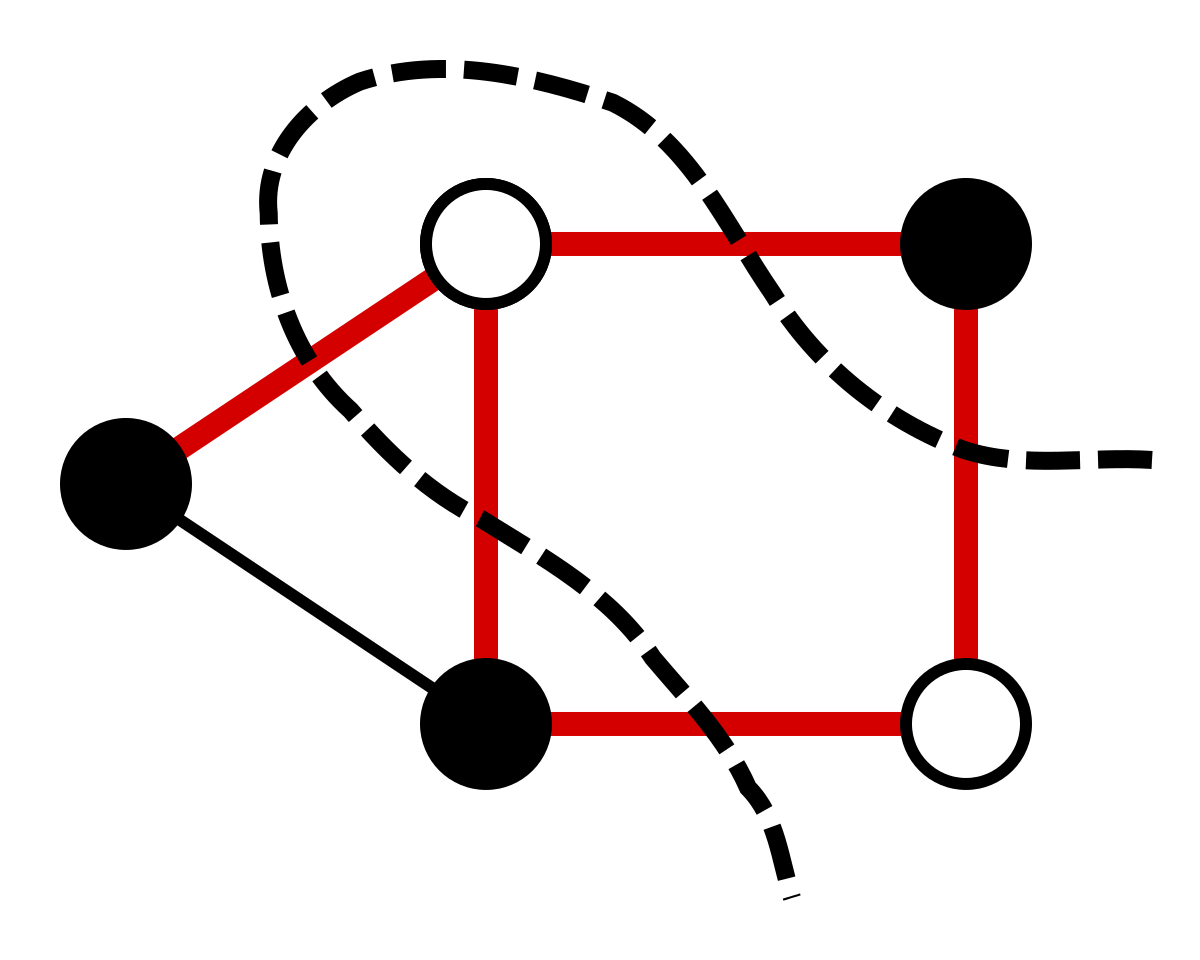
<center>

</center>

Let $G=(V,E)$ be a (weighted) graph with $n$ vertices and nonnegative edge weights $W_{ij}$ for vertices $(i,j)$. By numbering the vertices $x_1, \dots, x_n$, and assigning each vertex either the value 0 or 1, we can identify any cut of the graph with a vector $x \in \{0,1\}^n$ indicating which side of the cut it belongs to. Let's formulate the MaxCut problem, we know that we have to count toward any edge connecting two vertices (e.g. edge weighted by $W$ connects $x_i, x_j$) from different cuts by an amount $Wx_i(1-x_j)+Wx_j(1-x_i)$. It is apparent that as the cut tears $x_i$ and $x_j$ apart, which means one of either $x_i$ and $x_j$ are one and zero otherwise, the weigh of that edge $W$ contributes, otherwise the contribution is zero.  
The weight of a cut $x$ of the whole graph is then determined by the cost function
$$
C(x) = \sum_{i,j=1}^n W_{ij} x_i (1-x_j)
$$
where $W_{ij} = W_{ji}$ determines the weight of the edge connecting vertices $x_i$ and $x_j$, and $W_{ij} = 0$ if $x_i$ and $x_j$ are not connected by an edge. It is easy to see that each edge weight contributes exactly once to the sum if and only if $x_i \neq x_j$. <br>


Initialize our problem by creating a graph with $n=5$ nodes


In [ ]:
# Package to deal and visualize graphs
import rustworkx as rx
from rustworkx.visualization import mpl_draw
from typing import List
import matplotlib.pyplot as plt
import itertools

In [ ]:
n = 5

graph = rx.PyGraph()
graph.add_nodes_from(range(1, n + 1))
edge_list = [
    (0, 1, 1.0),
    (0, 2, 1.0),
    (1, 2, 1.0),
    (1, 3, 1.0),
    (2, 4, 1.0),
    (3, 4, 1.0),
]
graph.add_edges_from(edge_list)
pos = rx.spring_layout(graph, seed=2)
mpl_draw(graph, node_size=600, pos=pos, with_labels=True, labels=str)

The first step of the pattern is to map the classical problem (graph) into quantum circuits and operators. To do this, there are three main steps to take:
1. Utilize a series of mathematical reformulations, to represent this problem using the Quadratic Unconstrained Binary Optimization (QUBO) problems notation.
2. Rewrite the optimization problem as a Hamiltonian for which the ground state corresponds to the solution which minimizes the cost function.
3. Create a quantum circuit which will prepare the ground state of this Hamiltonian via a process similar to quantum annealing.

**Note**: In the QAOA methodology, you ultimately want to have an operator (Hamiltonian) that represents the cost function of our hybrid algorithm, as well as a parametrized circuit (Ansatz) that represents quantum states with candidate solutions to the problem. You can sample from these candidate states and then evaluate them using the cost function (similiar with the core idea of SQD approach which we will explore in the later notebook).

<div class="alert alert-block alert-success">

<p style="font-size:25px">
Exercise 3: MaxCut
</p>

For the newly defined graph above, find the maximum cut and pass it as a list of bits '$x=$\[$x_0, x_1, ..., x_n$\]' to the grader. You can use the following function which displays a bar plot of the cost function values for all possible bitstrings, but you need to add the code that computes the maxcut cost function value for a particular bitstring $x$. The numpy matrix `weight_matrix` refers to $W$ and you can access its elements $W_{ij}$ via `weight_matrix[i,j]`.

</div>

In [ ]:
def maxcut_cost_fn(graph: rx.PyGraph, bitstring: List[int]) -> float:
    """
    Computes the maxcut cost function value for a given graph and cut represented by some bitstring
    Args:
        graph: The graph to compute cut values for
        bitstring: A list of integer values '0' or '1' specifying a cut of the graph
    Returns:
        The value of the cut
    """
    #Get the weight matrix of the graph
    weight_matrix = rx.adjacency_matrix(graph)
    size = weight_matrix.shape[0]
    value = 0.

    ############################
    # Put your code here #



    ############################
    return value

def plot_maxcut_histogram(graph: rx.PyGraph) -> None:
    """
    Plots a bar diagram with the values for all possible cuts of a given graph.
    Args:
        graph: The graph to compute cut values for
    """
    num_vars = graph.num_nodes()
    #Create list of bitstrings and corresponding cut values
    bitstrings = ['{:b}'.format(i).rjust(num_vars, '0')[::-1] for i in range(2**num_vars)]
    values = [maxcut_cost_fn(graph = graph, bitstring = [int(x) for x in bitstring]) for bitstring in bitstrings]
    #Sort both lists by largest cut value
    values, bitstrings = zip(*sorted(zip(values, bitstrings)))

    values = np.array(values)

    # Normalize colors to map to colormap
    norm = (values - values.min()) / (values.max() - values.min())
    colors = plt.cm.plasma(norm)


    # Create figure and axis
    fig, ax = plt.subplots(figsize=(15,6))

    # Plot bars
    bars = ax.bar(bitstrings, values, color=colors)
    # Axis labels and title
    ax.set_xticklabels(bitstrings, rotation=45)
    ax.set_xlabel('Bitstring')
    ax.set_ylabel('Cut Value')
    ax.set_title('MaxCut Cost Landscape')

    # Add colorbar — use the axis we just created
    sm = plt.cm.ScalarMappable(cmap='plasma')
    sm.set_array(values)
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Cut Value')

    plt.tight_layout()
    plt.show()

In [ ]:
plot_maxcut_histogram(graph = graph)

🎉 🎉 We can see that, two cutting ways corresponds to the bitstrings `11001` (or `00110`) and `10110` (or `01001`) reach the max cut value

### MaxCut as a Quadratic Program
We can formulate any MaxCut problem as a quadratic program. Consider again the cost function for a MaxCut problem with symmetric weight matrix $W$
$$
C(x) = \sum_{i,j=1}^n W_{ij} x_i (1-x_j).
$$
This is clearly a quadratic cost function and we can reformulate it in the standard form for quadratic programs as written above.
$$
\begin{align*}
\sum_{i,j=1}^n W_{ij} x_i (1-x_j) &= \sum_{i,j=1}^n W_{ij} x_i - W_{ij}x_i x_j  \\
&= \sum_{i=1}^n \left( \sum_{j=1}^n W_{ij} \right) x_i - \sum_{i,j = 1}^n W_{ij}x_i x_j \\
&= c^T x + x^T Q x, \\
\end{align*}
$$
for $Q$ and $c$ defined as follows
$$
Q_{ij} = -W_{ij} \qquad c_i = \sum_{j=1}^n W_{ij}.
$$
Thus, we obtain an optimization instance with binary variables, a quadratic objective function and without any variable constraints. A quadratic program of such a form is also known as a Quadratic Unconstrained Binary Optimization (QUBO) problem. In the next section, we will learn how to use QAOA to optimize problems of that type.

<div class="alert alert-block alert-success">
    
<p style="font-size:25px">
Exercise 4: MaxCut to QUBO
</p>
    
The following function should construct a quadratic program from a MaxCut problem instance defined by a graph. Complete the code, using the methods explained in the previous section. You will have to add binary variables to the quadratic program which should be named 'x_0', 'x_1', ..., 'x_n'. We refer to the weight matrix $W$ as `weight_matrix` and to the qubo matrix $Q$ as `qubo_matrix`.

</div>

In [ ]:
def quadratic_program_from_graph(graph: rx.PyGraph) -> QuadraticProgram:
    """Constructs a quadratic program from a given graph for a MaxCut problem instance.
    Args:
        graph: Underlying graph of the problem.
    Returns:
        QuadraticProgram
    """
    #Get weight matrix of graph
    weight_matrix = rx.adjacency_matrix(graph)
    shape = weight_matrix.shape
    size = shape[0]
    #Build qubo matrix Q from weight matrix W
    qubo_matrix = np.zeros((size, size))
    qubo_vector = np.zeros(size)

    ############################
    # Put your code here #



    ############################

    quadratic_program = QuadraticProgram('MaxCut as QUBO')

    ############################
    # Put your code here #


    ############################

    quadratic_program.maximize(quadratic = qubo_matrix, linear = qubo_vector)

    return quadratic_program

In [ ]:
quadratic_program = quadratic_program_from_graph(graph)
print(quadratic_program.prettyprint())

Problem name: MaxCut as QUBO

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_1*x_2 - 2*x_1*x_3 - 2*x_2*x_4 - 2*x_3*x_4 + 2*x_0
  + 3*x_1 + 3*x_2 + 2*x_3 + 2*x_4

Subject to
  No constraints

  Binary variables (5)
    x_0 x_1 x_2 x_3 x_4



Congratulations 🎉! You’ve successfully converted the MaxCut graph problem into a QUBO form — the key step that allows it to be solved using a quantum optimization algorithm such as QAOA. Next, we will learn how to reformulate **the QUBO problem as a Hamiltonian**

### QUBO to Hamiltonian

To demonstrate how QUBO problem can be rewritten in Hamiltonian way, first replace the binary variables $x_i$ to a new set of variables $z_i \in \{-1,1\}$ by $$x_i = \frac{1-z_i}{2}.$$
Substitute $x_i \in \{0,1\}$ by its new expression in terms of $z_i \in \{-1,1\}$ in the optimization problem $max_{x\in \{0,1\}^n}C(x)$, we get the new equivalent formulation
$$
max_{z\in \{-1,1\}^n}C(z)= max_{z\in \{-1,1\}^n}\sum_{i,j=1}^n \frac{1}{4}Q_{ij} z_i z_j - \sum_{i=1}^n \frac{1}{2} \left(c_i + \sum_{j=1}^n Q_{ij} \right) z_i +  \left( \sum_{i,j=1}^n \frac{Q_{ij}}{4} + \sum_{i=1}^n \frac{c_i}{2} \right).
$$
Now, to obtain a quantum formulation of the problem, promote the $z_i$ variables to the Pauli $Z_i$ matrix, we remove the constant term at the end which do not play a role in the optimization, notice that from above definitions  $ \left(c_i + \sum_{j=1}^n Q_{ij} \right)=0$ and then define $J_{ij}= \frac{1}{2}Q_{ij}$, we obtain the following Hamiltonian
$$
H_C = \sum_{i,j} \frac{1}{2}J_{ij} Z_i Z_j .
$$

That is the form of finding Ising model Hamiltonian, where we know well how to solve it and be easy to implement on quantum devices. If changing $W_{i,j}\rightarrow -W_{ij}$, we switch the problem into finding the minimum energy of a Hamiltonian, which we have already got familiar at above in the procedure of VQE. Therefore, **its ground state corresponds to the solution that obtains the MaxCut problem**. Therefore, to solve your optimization problem you now need to prepare the ground state of $H_C$ (or a state with a high overlap with it) on the quantum computer. Then, sampling from this state will, with a high probability, yield the solution.


### QAOA Variational Form

Remember that, in VQE, one of the key factors determining the algorithm’s success is the choice of ansatz (parametrized quantum circuit). In QAOA, the ansatz is constructed using a unitary $U(\boldsymbol{\beta}, \boldsymbol{\gamma})$ characterized by the parameters $(\boldsymbol{\beta}, \boldsymbol{\gamma})$ to prepare a quantum state $|\psi(\boldsymbol{\beta}, \boldsymbol{\gamma})\rangle$, by applying these unitaries as alternating blocks of the two unitaries applied $p$ times such that
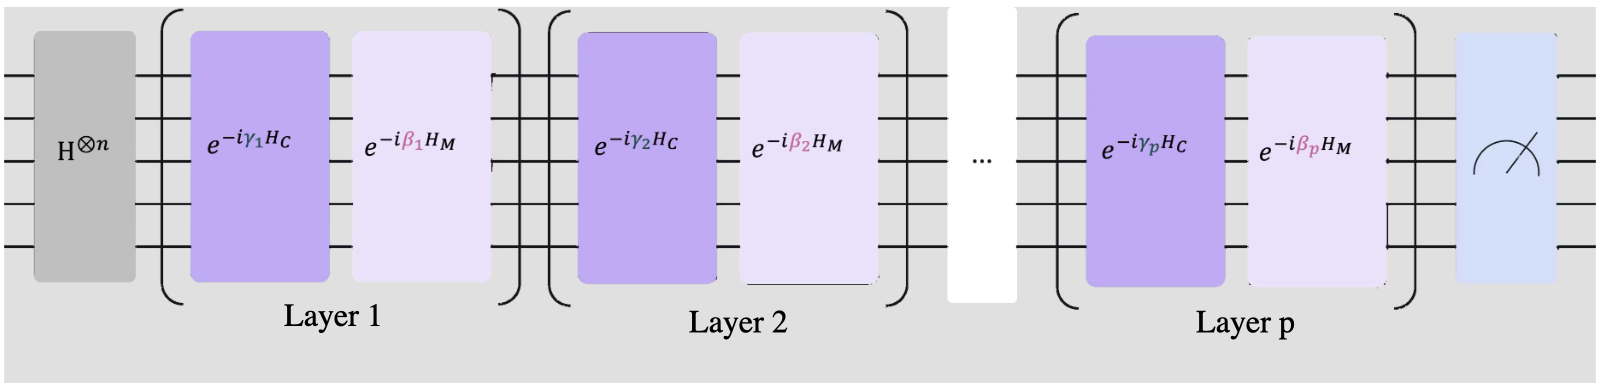
$$
\lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle = \underbrace{U(\boldsymbol{\beta}) U(\boldsymbol{\gamma})
                                            \cdots U(\boldsymbol{\beta}) U(\boldsymbol{\gamma})}_{p \; \text{times}}
\lvert \psi_0 \rangle
$$
where $|\psi_{0}\rangle$ is chosen as $|\psi_{0}\rangle = H^{\otimes n}|0\rangle$.

The unitary $U(\boldsymbol{\beta}, \boldsymbol{\gamma})$ has a specific form and is composed of two unitaries $U(\boldsymbol{\beta}) = e^{-i \boldsymbol{\beta} H_M}$ and $U(\boldsymbol{\gamma}) = e^{-i \boldsymbol{\gamma} H_C}$ where $H_{M}$ is the mixing Hamiltonian and $H_{C}$ is the problem Hamiltonian. Exponentiating both Hamiltonians, we obtain a variational from consisting $R_{ZZ}$ gates in the cost layer and $R_X$ gates in the mixer layer
$$
e^{- i \beta H_M} = \prod_{i=1}^n R_{X_i}(2\beta) \quad \quad e^{- i \gamma H_C} = \prod_{i,j=1 \\ i \neq j}^n R_{Z_iZ_j} \left( \frac{1}{2} Q_{ij} \gamma \right)
$$

The first idea of QAOA is proposed by Farhi, Goldstone, and Gutmann (2014)[**[1]**](https://arxiv.org/abs/1411.4028), where Such a applies alternating layers of unitary operators in the quantum circuit drives its inspiration from a related scheme called quantum annealing. The general idea is to start in the ground state of a known system $H_{M}$, $H^{\otimes n}|0\rangle$ above,  and then steer the system into the ground state of the cost operator that you are interested in. This is done by applying the operators $e^{-i \boldsymbol{\gamma} H_C}$ and $e^{-i \boldsymbol{\beta} H_M}$ with variable parameters $(\boldsymbol{\beta}, \boldsymbol{\gamma})$ and do the hybrid quantum-classical loop to achieve the optimal solution.


> Add blockquote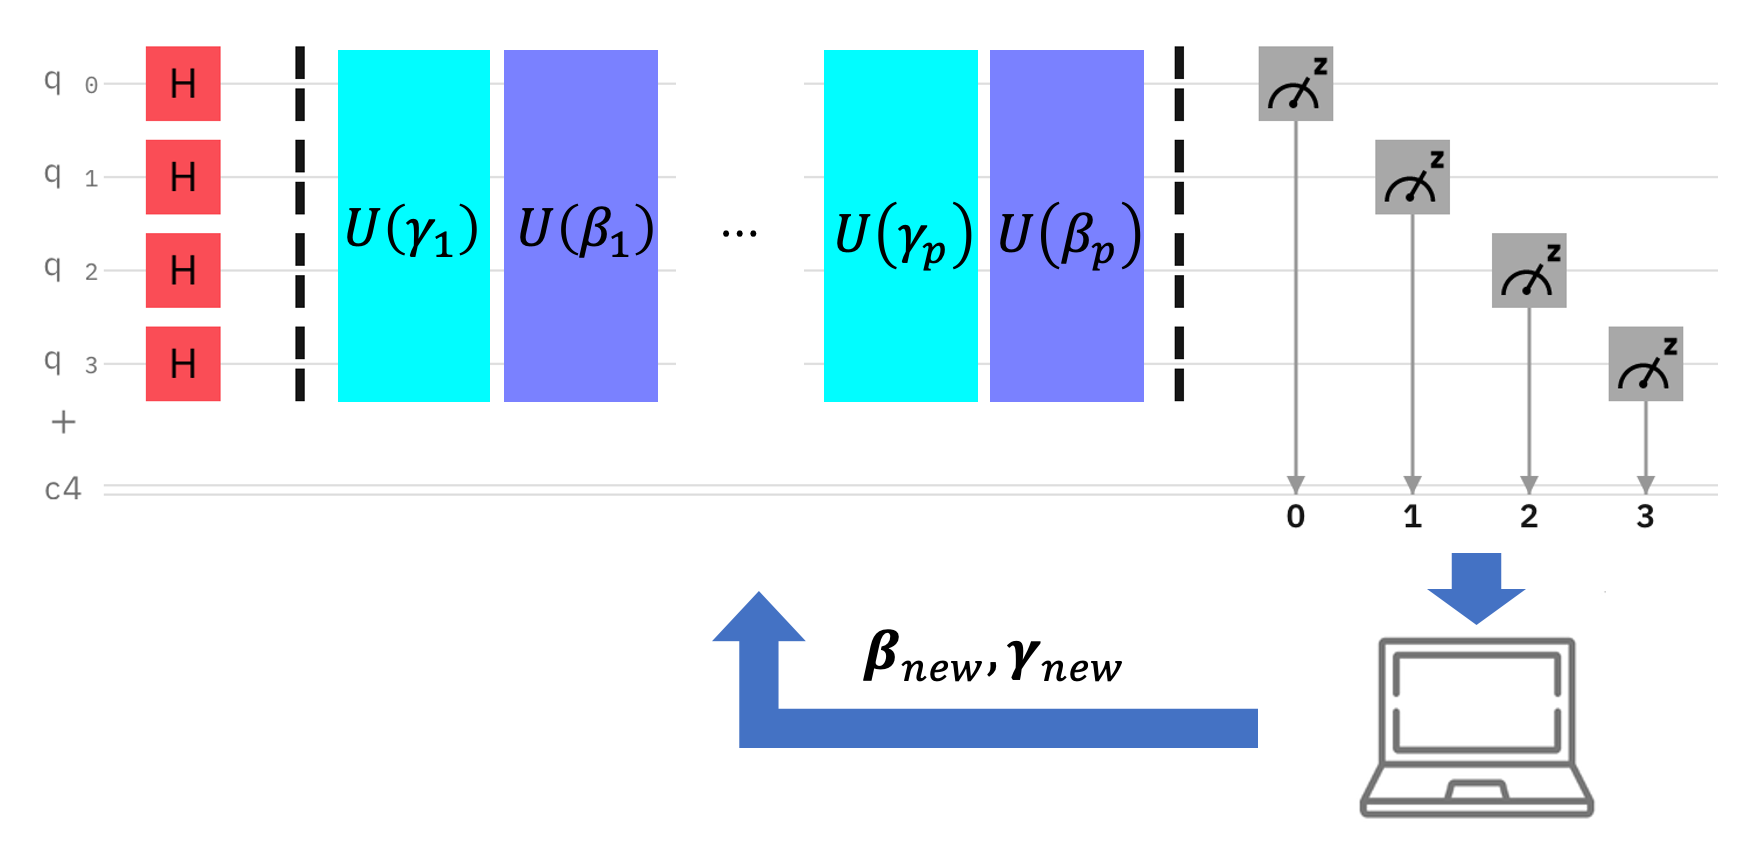



<div class="alert alert-block alert-success">

<p style="font-size:25px">
Exercise 5: QAOA Variational Form
</p>

Write a function that takes as input a quadratic program and a parameter $p$, and produces as output the corresponding QAOA circuit with $p$ layers. The basic construct of the function is provided below, but you will have to insert the parts where the cost and mixer layers are applied. You will need to calculate the angles of the rotational gates as described in the final equations above. In the code below, we refer to the qubo matrix $Q$ as `qubo_matrix`, and to the vector $c$ as `qubo_linearity`. Make sure not to include any measurements in the circuit.

</div>

In [ ]:
def qaoa_circuit(qubo: QuadraticProgram, p: int = 1):
    """
    Given a QUBO instance and the number of layers p, constructs the corresponding parameterized QAOA circuit with p layers.
    Args:
        qubo: The quadratic program instance
        p: The number of layers in the QAOA circuit
    Returns:
        The parameterized QAOA circuit
    """
    size = len(qubo.variables)
    qubo_matrix = qubo.objective.quadratic.to_array(symmetric=True)

    #Prepare the quantum and classical registers
    qaoa_circuit = QuantumCircuit(size,size)
    #Apply the initial layer of Hadamard gates to all qubits
    qaoa_circuit.h(range(size))

    #Create the parameters to be used in the circuit
    gammas = ParameterVector('gamma', p)
    betas = ParameterVector('beta', p)

    #Outer loop to create each layer
    for i in range(p):

        #Apply R_ZZ rotational gates for entangled qubit rotations from cost layer
        ############################
        # Put your code here #


        ############################

        # Apply single qubit X - rotations with angle 2*beta_i to all qubits
        ############################
        # Put your code here #


        ############################

    return qaoa_circuit

In [ ]:
quadratic_program = quadratic_program_from_graph(graph)
custom_circuit = qaoa_circuit(qubo = quadratic_program)
custom_circuit.draw("mpl")

Congratulations 🎉! You’ve just successfully built your first QAOA circuit

However, in Qiskit workflow, we will build the Hamiltonian from graph and pass it dirrectly to `QAOAAnsatz` to generate the circuit.
Therefore, we need to define the hamiltonian operators first, using the formulation defined above

<div class="alert alert-block alert-success">

<p style="font-size:25px">
Exercise 6: Hamiltonian for QAOA problem
</p>

Write a function that takes as input a graph then produces as output the corresponding $H_C$. Using the rx.PyGraph functions, `rx.PyGraph.edge_list()` and/or `rx.PyGraph.edge_data()`, to get the information that is able to identify operators and their weights.

</div>

In [ ]:
def build_max_cut_operator(graph: rx.PyGraph) -> tuple[SparsePauliOp, float]:
    sp_list = []

     ############################
    # Put your code here #


    ############################

    return SparsePauliOp.from_sparse_list(
        sp_list, num_qubits=graph.num_nodes()
    )

In [ ]:
cost_hamiltonian = build_max_cut_operator(graph)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Congratulations 🎉! You’ve successfully get $H_C$ from your graph

Pass the `SparsePauliOp` object to `QAOAAnsatz` ansatz to get the circuit

In [ ]:
from qiskit.circuit.library import QAOAAnsatz

In [ ]:
# You can adjust the reps yourself to see better performance
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()
circuit.draw("mpl")

In [ ]:
circuit.decompose(reps=3).draw("mpl", fold=-1)

### Run QAOA on Qiskit

In the QAOA workflow, the optimal QAOA parameters are found in an iterative optimization loop, which runs a series of circuit evaluations and uses a classical optimizer to find the optimal $(\boldsymbol{\beta}, \boldsymbol{\gamma})$ parameters. This execution loop is executed via the following steps:
1. Define the initial parameters
2. Instantiate a hybrid loop containing the optimization and the primitive used to sample the circuit
3. Once an optimal set of parameters is found, execute the circuit a final time to obtain a final distribution which will be used in the post-process step.

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Use a quantum device
# QiskitRuntimeService.save_account(channel="ibm_quantum_platform", token="YOUR_API_TOKEN", set_as_default=True, overwrite=True)
# service = QiskitRuntimeService('ibm_quantum_platform')
# backend = service.least_busy(min_num_qubits=127)
# backend = service.backend("ibm_kingston")

# You can test your programs locally with a fake backend (local testing mode)
backend = FakeBrisbane()

print(backend)

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)

candidate_circuit = pm.run(circuit)
candidate_circuit.draw("mpl", fold=False, idle_wires=False)

In [ ]:
# start with arbitrary chosen parameters.
initial_gamma = np.pi
initial_beta = np.pi / 2
init_params = [initial_gamma, initial_beta, initial_gamma, initial_beta, initial_gamma, initial_beta, initial_gamma, initial_beta]

<div class="alert alert-block alert-success">

<p style="font-size:25px">
Exercise 7: QAOA Cost Function
</p>

Write a cost function for the QAOA algorithm, which takes variable paramters, quantum circuit, hamiltonian operators and estimator as inputs

</div>

In [ ]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    ############################
    # Put your code here #


    ############################

    objective_func_vals.append(cost) # Do not change this, it is a global variable

    return cost

In [ ]:
# from qiskit_ibm_runtime import Session, EstimatorV2
from scipy.optimize import minimize

**Warning: If you cannot access the IBM account to get the API token, move to run the next cell**

In [ ]:
# # Run this cel if you use a real backend
# objective_func_vals = []  # Global variable
# with Session(backend=backend) as session:
#     # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
#     estimator = EstimatorV2(mode=session)
#     estimator.options.default_shots = 1000

#     # Set simple error suppression/mitigation options
#     estimator.options.dynamical_decoupling.enable = True
#     estimator.options.dynamical_decoupling.sequence_type = "XY4"
#     estimator.options.twirling.enable_gates = True
#     estimator.options.twirling.num_randomizations = "auto"

#     result = minimize(
#         cost_func_estimator,
#         init_params,
#         args=(circuit, cost_hamiltonian, estimator),
#         method="COBYLA",
#         tol=1e-2,
#     )
#     print(result)

**Run this cell if you use local simulator**

In [ ]:
# Local testing mode with StatevectorEstimator
# Using minimize scipy for the hybrid quantum-classical optimization loop
objective_func_vals = []  # Global variable
circuit.remove_final_measurements()
estimator = StatevectorEstimator()
result = minimize(
    cost_func_estimator,
    init_params,
    args=(circuit, cost_hamiltonian, estimator),
    method="COBYLA",
    tol=1e-2,
)
print(result)

In [ ]:
# Plot the convergence of the optimization
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

Once you have found the optimal parameters for the circuit, you can assign these parameters and sample the final distribution obtained with the optimized parameters. Here is where the Sampler primitive should be used since it is the probability distribution of bitstring measurements which correspond to the optimal cut of the graph. This means preparing a quantum state in the computer and then measuring it

**Warning: If you cannot access the IBM account to get the API token, move to run the next two cells**

In [ ]:
# optimized_circuit = candidate_circuit.assign_parameters(result.x)
# optimized_circuit.draw("mpl", fold=False, idle_wires=False)

In [ ]:
# from qiskit_ibm_runtime import SamplerV2

# # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
# sampler = SamplerV2(mode=backend)

# # Set simple error suppression/mitigation options
# sampler.options.dynamical_decoupling.enable = True
# sampler.options.dynamical_decoupling.sequence_type = "XY4"
# sampler.options.twirling.enable_gates = True
# sampler.options.twirling.num_randomizations = "auto"

# pub = (optimized_circuit,)
# job = sampler.run([pub], shots=int(1e4))
# counts_int = job.result()[0].data.meas.get_int_counts()
# counts_bin = job.result()[0].data.meas.get_counts()
# shots = sum(counts_int.values())
# final_distribution_int = {key: val / shots for key, val in counts_int.items()}
# final_distribution_bin = {key: val / shots for key, val in counts_bin.items()}
# print(final_distribution_int)

**Run this cell if you use local simulator**

In [ ]:
optimized_circuit = circuit.assign_parameters(result.x)
optimized_circuit.measure_all()
optimized_circuit.draw("mpl", fold=False, idle_wires=False)

In [ ]:
# Local testing mode with StatevectorSampler
sampler = StatevectorSampler()


pub = (optimized_circuit,)
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val / shots for key, val in counts_int.items()}
final_distribution_bin = {key: val / shots for key, val in counts_bin.items()}
print(final_distribution_int)

The post-processing step interprets the sampling output to return a solution for your original problem. In this case, you are interested in the bitstring with the highest probability as this determines the optimal cut. The symmetries in the problem allow for four possible solutions, and the sampling process will return one of them with a slightly higher probability, but you can see in the plotted distribution below that four of the bitstrings are distinctively more likely than the rest.

In [ ]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]


keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

In [ ]:
import matplotlib.pyplot as plt

# Sample plot of the final distribution
plt.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[p[0].item()].set_color("tab:purple")
plt.show()

From the optimal bit string, you can then visualize this cut on the original graph.

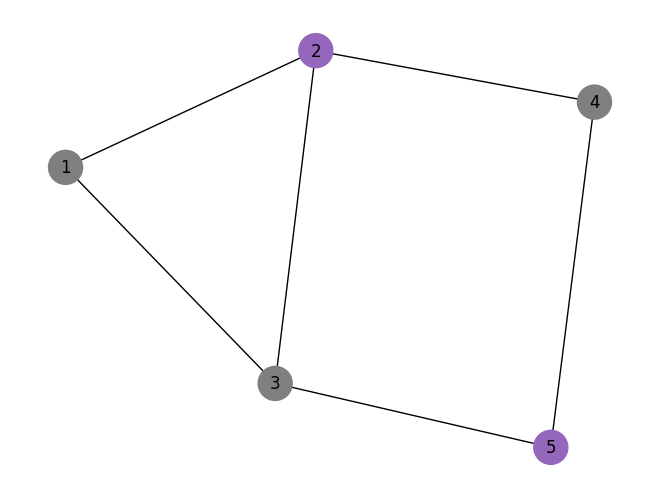

In [ ]:
colors = ["tab:grey" if i == 0 else "tab:purple" for i in most_likely_bitstring]
mpl_draw(graph, node_size=600, pos=pos, with_labels=True, labels=str, node_color=colors)

And calculate the value of the cut. The solution is not optimal due to noise (the cut value of the optimal solution is 5). If you cannot get Maxcut value 5, try to adjust your ansatz

In [ ]:
from typing import Sequence


def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(
        list(graph.nodes())
    ), "The length of x must coincide with the number of nodes in the graph."
    return sum(
        x[u] * (1 - x[v]) + x[v] * (1 - x[u]) for u, v in list(graph.edge_list())
    )


cut_value = evaluate_sample(most_likely_bitstring, graph)
print("The value of the cut is:", cut_value)

The value of the cut is: 5


Congratulations 🎉! You got the Max Cut value

### The Qiskit end-to-end QAOA class
If you have managed to complete the previous exercises, congratulations! You have implemented your own version of QAOA that can solve general QUBO instances and in particular MaxCut problems by running on a quantum computer. Qiskit also provides its own implementation of QAOA which allows us to solve optimization problems with only a few lines of code. <br>
The `QAOA` class in Qiskit is located in `qiskit_algorithms` and directly inherits from the Variational Quantum Eigensolver class `VQE`. The initializer for `QAOA` takes the following input parameters, amongst others
- `sampler`: The qiskit primitive to sample the circuits. This can be a simulator or a real hardware device.
- `optimizer`: This argument refers to the classical optimizer used for updating the circuit parameters. Qiskit offers a number of different optimizers and you can also define your own by subclassing Qiskit's native `Optimizer` class. Some of the basic optimizers offered by Qiskit are the following: <br>
    - COBYLA: Constrained Optimization By Linear Approximation optimizer.
    - ADAM:  A gradient-based optimization algorithm that is relies on adaptive estimates of lower-order moments.
    - SPSA: a technique that involves stochastic approximating the gradient of a quantum circuit without having to compute it exactly.
- `reps`: The number of layers $p$ in the QAOA variational form, i.e. the depth of the algorithm. For higher values of $p$, QAOA can theoretically obtain better results but the quantum circuit becomes deeper and there are more parameters to optimize.
- `initial_state`: Optional initial parameter values (values for $\beta$ and $\gamma$) to start the optimization with.
- `callback`: A callback function that can be used to monitor the optimization process.

Below, you will be able to test the effect of some of these arguments on the optimization procedure of QAOA.

In [ ]:
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA, ADAM, SPSA
sampler = StatevectorSampler(seed=42)
# You can try with different optimizers
optimizer = COBYLA()
qaoa = QAOA(sampler, optimizer=optimizer, reps=3)
cost_hamiltonian= build_max_cut_operator(graph)
print("Cost Function Hamiltonian:", cost_hamiltonian)
result = qaoa.compute_minimum_eigenvalue(cost_hamiltonian)
print(result.best_measurement)

/var/folders/hw/0nyvyd510k7fglch1k_288mh0000gn/T/ipykernel_34738/523072507.py:29: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



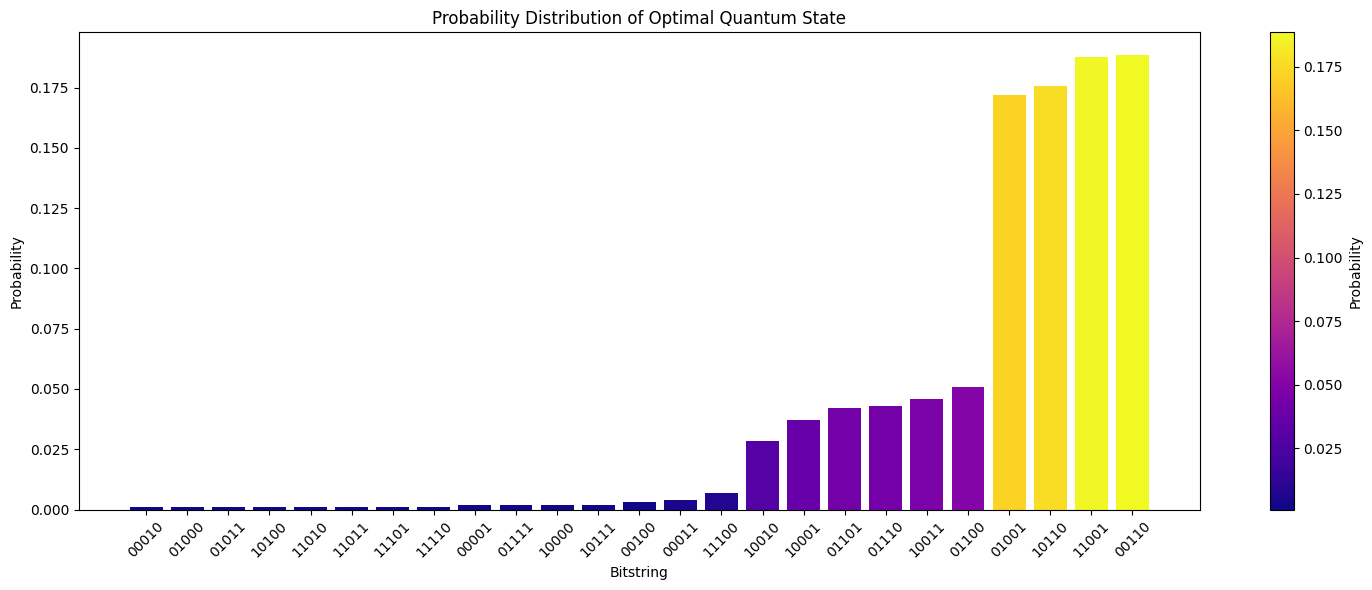

In [ ]:
def plot_samples(samples):
    """
    Plots a bar diagram for the samples of a quantum algorithm
    Args:
        samples
    """
    #Sort samples by probability
    samples = sorted(samples.items(), key = lambda item: item[1])
    #Get list of probabilities, function values and bitstrings
    probabilities = [sample[1] for sample in samples]
    values = [sample[0][::-1] for sample in samples]
    #Sort both lists by largest probability
    values, bitstrings = zip(*sorted(zip(probabilities, values)))

    values = np.array(values)

    # Normalize colors to map to colormap
    norm = (values - values.min()) / (values.max() - values.min())
    colors = plt.cm.plasma(norm)


    # Create figure and axis
    fig, ax = plt.subplots(figsize=(15,6))

    # Plot bars
    bars = ax.bar(bitstrings, values, color=colors)
    # Axis labels and title
    ax.set_xticklabels(bitstrings, rotation=45)
    ax.set_xlabel('Bitstring')
    ax.set_ylabel('Probability')
    ax.set_title('Probability Distribution of Optimal Quantum State')

    # Add colorbar — use the axis we just created
    sm = plt.cm.ScalarMappable(cmap='plasma')
    sm.set_array(values)
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Probability')

    plt.tight_layout()
    plt.show()

plot_samples(result.eigenstate)

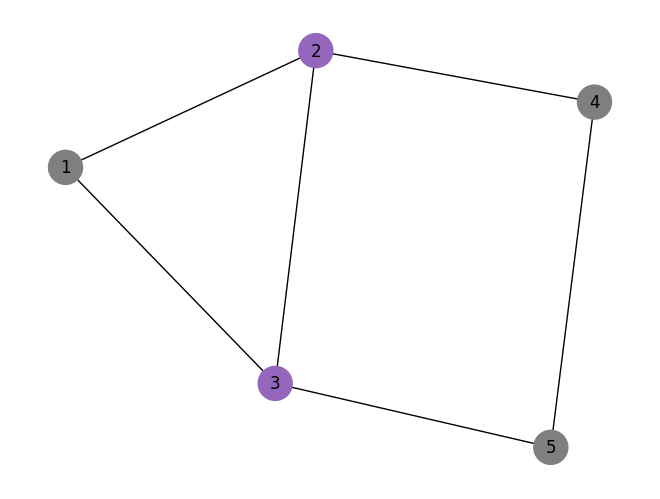

In [ ]:
# Visualize the optimal solution from QAOA
colors = ["tab:grey" if i == '0' else "tab:purple" for i in samples[-1][0][::-1]]
mpl_draw(graph, node_size=600, pos=pos, with_labels=True, labels=str, node_color=colors)

In [ ]:
# Get then value of the cut
cut_value = evaluate_sample(most_likely_bitstring, graph)
print("The value of the cut is:", cut_value)

The value of the cut is: 5


# Reference

\[1] Peruzzo, A.; McClean, J.; Shadbolt, P.; Yung, M.-H.; Zhou, X.-Q.; Love, P. J.; Aspuru-Guzik, A.; O’Brien, J. “A variational eigenvalue solver on a quantum processor.” [arXiv preprint arXiv:1304.3061 (2013).](https://arxiv.org/abs/1304.3061)

\[2] Farhi, E.; Goldstone, J.; Gutmann, S. “A Quantum Approximate Optimization Algorithm.” [arXiv preprint arXiv:1411.4028 (2014).](https://arxiv.org/abs/1411.4028)

\[3] Le, D.-T.; Nguyen, V.-L.; Nguyen, C.-H.; Nguyen, Q.-H.; Nguyen, V.-D. “Variational Quantum Eigensolver: A Comparative Analysis of Classical and Quantum Optimization Methods.” [arXiv preprint arXiv:2412.19176 (2024).](https://arxiv.org/abs/2412.19176)

\[4] Quantum algorithms: Variational quantum algorithms, [IBM Quantum Learning.](https://quantum.cloud.ibm.com/learning/en)

\[5] Qiskit Global Summer School 2021 and Qiskit challanges 2021 hosted by IBM Quantum

**Created by:** Le Duc Truyen

**Reviewed by:**  ....



<div class="alert alert-info">

© Paris-Saclay Quantum Team., 2025